# Plant Disease Classification with Background Bias Reduction

## Introduction

This notebook provides a complete and reproducible pipeline for plant disease classification using deep learning.
The workflow covers dataset downloading, preprocessing, model training, and evaluation.

The study is conducted in two stages:
- Stage 1: Baseline CNN and EfficientNetB0 fine-tuning.
- Stage 2: Background bias mitigation using leaf-focused training.

All experiments can be reproduced by running this notebook sequentially.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
%cd /content/drive/MyDrive/plant-disease-background-bias

/content/drive/MyDrive/plant-disease-background-bias


In [ ]:
!pip install -r requirements.txt

##1. Download Dataset

In [3]:
!python src/download_data.py

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: c
Your Kaggle Key: 
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
 97% 640M/658M [00:04<00:00, 119MB/s]
100% 658M/658M [00:04<00:00, 139MB/s]
Dataset ready.
Number of classes: 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


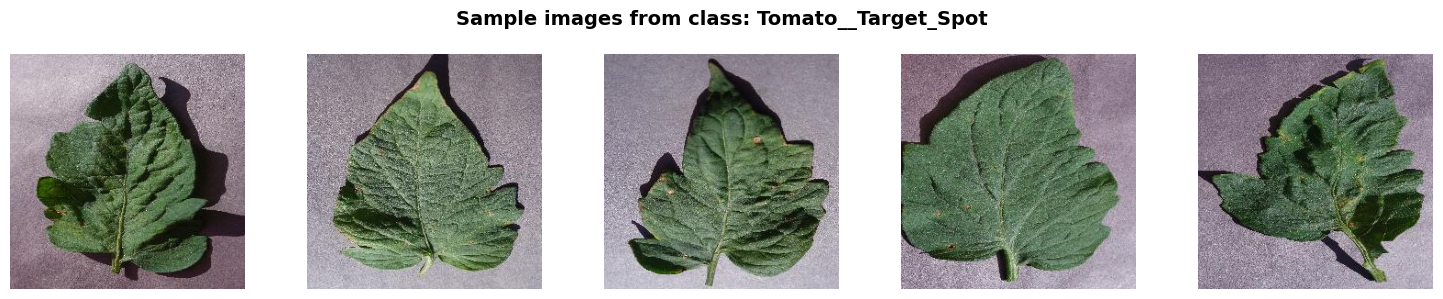

In [4]:
import random
import os
import matplotlib.pyplot as plt

# Base directory
base_dir = "/content/plantdisease/PlantVillage"

# List classes
classes = sorted([
    c for c in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, c))
])

# Pick random class
sample_class = random.choice(classes)
sample_dir = os.path.join(base_dir, sample_class)

# Pick first 5 images
sample_images = [
    f for f in os.listdir(sample_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
][:5]

# Plot
plt.figure(figsize=(15, 3))
for i, img_file in enumerate(sample_images):
    img_path = os.path.join(sample_dir, img_file)
    img = plt.imread(img_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.suptitle(f"Sample images from class: {sample_class}", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()


#2. Stratified Dataset Split

In [5]:
!python src/split_data.py

Preparing stratified train/val/test split...

Per-class distribution after split:
                                          Class  Train  Val  Test  Total
0         Tomato__Tomato_YellowLeaf__Curl_Virus   2245  481   482   3208
1                         Tomato_Bacterial_spot   1488  319   320   2127
2                            Tomato_Late_blight   1336  286   287   1909
3                     Tomato_Septoria_leaf_spot   1239  265   267   1771
4   Tomato_Spider_mites_Two_spotted_spider_mite   1173  251   252   1676
5                                Tomato_healthy   1113  238   240   1591
6                        Pepper__bell___healthy   1034  221   223   1478
7                           Tomato__Target_Spot    982  210   212   1404
8                         Potato___Early_blight    700  150   150   1000
9                          Potato___Late_blight    700  150   150   1000
10                          Tomato_Early_blight    700  150   150   1000
11                Pepper__bell___Bacterial

## 3. Stage-1 Training

In [ ]:
 #Experiment 1 — Baseline CNN (Scratch)
!touch src/__init__.py

In [ ]:
!python -m src.stage1_train

In [ ]:
# ===============================
# Stage-1 Evaluation


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)

# ---------- Paths ----------
DATA_ROOT = "/content/plantdisease_split"
BASELINE_PATH = "outputs/stage1/models/baseline.h5"
EFFNET_PATH   = "outputs/stage1/models/effnet_finetune.h5"

# ---------- Generators ----------
test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    DATA_ROOT + "/test",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    DATA_ROOT + "/val",
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

class_names = list(test_gen.class_indices.keys())

# ---------- Load models ----------
baseline = load_model(BASELINE_PATH, compile=False)
eff_ft   = load_model(EFFNET_PATH, compile=False)

Found 3109 images belonging to 15 classes.
Found 3089 images belonging to 15 classes.


In [ ]:

# 1) Training Curves Comparison (Accuracy + Loss)

import json

hist_baseline = json.load(open("outputs/stage1/history/baseline.json"))
hist_ft       = json.load(open("outputs/stage1/history/effnet.json"))

class HistoryWrapper:
    def __init__(self, h): self.history = h

hist_baseline = HistoryWrapper(hist_baseline)
hist_ft       = HistoryWrapper(hist_ft)

def plot_comparison_histories(histories, metric="accuracy", title="Accuracy Comparison"):
    plt.figure(figsize=(8,5))
    for label, hist in histories.items():
        plt.plot(hist.history[metric], label=f"{label} Train")
        plt.plot(hist.history["val_"+metric], linestyle="--", label=f"{label} Val")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

histories = {
    "Baseline": hist_baseline,
    "EffNet FineTune": hist_ft
}

plot_comparison_histories(histories, metric="accuracy", title="Accuracy Comparison")
plot_comparison_histories(histories, metric="loss", title="Loss Comparison")


In [ ]:
# 2) Confusion Matrix (EfficientNet only)

def plot_conf_matrix(model, gen, split_name="Validation"):
    y_true = gen.classes
    y_pred = np.argmax(model.predict(gen, verbose=0), axis=1)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10,8))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

plot_conf_matrix(eff_ft, val_gen,  "Validation (EffNet FT)")
plot_conf_matrix(eff_ft, test_gen, "Test (EffNet FT)")

In [ ]:
# 3) Classification Report (EfficientNet)

def eval_classification(model, gen, split_name="Validation"):
    y_true = gen.classes
    y_pred = np.argmax(model.predict(gen, verbose=0), axis=1)
    print(f"\n=== {split_name} Report ===")
    print(classification_report(
        y_true, y_pred,
        target_names=class_names,
        digits=3
    ))

eval_classification(eff_ft, val_gen,  "Validation (EffNet FT)")
eval_classification(eff_ft, test_gen, "Test (EffNet FT)")



In [ ]:

# 4) Numerical Test Comparison + Bar Chart


def evaluate_on_test(model, gen, model_name="Model"):
    y_true = gen.classes
    y_pred = np.argmax(model.predict(gen, verbose=0), axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro"
    )

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Macro Precision": prec,
        "Macro Recall": rec,
        "Macro F1": f1
    }

results = []
results.append(evaluate_on_test(baseline, test_gen, "Baseline CNN"))
results.append(evaluate_on_test(eff_ft,   test_gen, "EffNet FineTune"))

df_results = pd.DataFrame(results)
print("\n=== Test Results (Numerical) ===")
print(df_results)

# ---------- Bar Plot ----------
metrics = ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1"]

plt.figure(figsize=(10,6))
x = np.arange(len(metrics))
width = 0.25

for i, row in enumerate(df_results.iterrows()):
    label = row[1]["Model"]
    values = [row[1][m] for m in metrics]
    plt.bar(x + i*width, values, width=width, label=label)

plt.xticks(x + width, metrics, rotation=20)
plt.ylim(0,1.05)
plt.title("Test Set Comparison Across Models")
plt.ylabel("Score")
plt.legend()
plt.show()

#Stage-2 Pipeline (Warm-start) — Background Bias Removal
Model 2 : using model and weights from stage 1

In [ ]:
!python -m src.stage2_train

#Stage-2 Evaluation

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ===== Paths =====
OUT_DIR   = Path("outputs/stage2")
HIST_PATH = OUT_DIR / "history_stage2.json"
SAVE_PNG  = OUT_DIR / "training_curve.png"

# ===== Load history from Stage-2 =====
with open(HIST_PATH, "r") as f:
    history = json.load(f)

histA = history["phaseA"]
histB = history["phaseB"]

# ===== Plot function =====
def plot_training_history(histA, histB, save_path=None):
    """
    Plot training curves for Stage-2:
    Phase A (warm-start) + Phase B (mixed refinement)
    """

    accA, val_accA = histA["accuracy"], histA["val_accuracy"]
    lossA, val_lossA = histA["loss"], histA["val_loss"]

    accB, val_accB = histB["accuracy"], histB["val_accuracy"]
    lossB, val_lossB = histB["loss"], histB["val_loss"]

    total_epochs = len(accA) + len(accB)

    phaseA_epochs = np.arange(1, len(accA) + 1)
    phaseB_epochs = np.arange(len(accA) + 1, total_epochs + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # ===== Accuracy =====
    ax1.plot(phaseA_epochs, accA, 'b-', label='Phase A Train', alpha=0.8)
    ax1.plot(phaseA_epochs, val_accA, 'b--', label='Phase A Val', alpha=0.8)

    ax1.plot(phaseB_epochs, accB, 'r-', label='Phase B Train', alpha=0.8)
    ax1.plot(phaseB_epochs, val_accB, 'r--', label='Phase B Val', alpha=0.8)

    ax1.axvline(x=len(accA) + 0.5, color='gray', linestyle=':', alpha=0.7)
    ax1.set_title("Stage-2 Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # ===== Loss =====
    ax2.plot(phaseA_epochs, lossA, 'b-', label='Phase A Train', alpha=0.8)
    ax2.plot(phaseA_epochs, val_lossA, 'b--', label='Phase A Val', alpha=0.8)

    ax2.plot(phaseB_epochs, lossB, 'r-', label='Phase B Train', alpha=0.8)
    ax2.plot(phaseB_epochs, val_lossB, 'r--', label='Phase B Val', alpha=0.8)

    ax2.axvline(x=len(accA) + 0.5, color='gray', linestyle=':', alpha=0.7)
    ax2.set_title("Stage-2 Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    # ===== Final metrics =====
    print("Final Phase-B Training Accuracy :", f"{accB[-1]:.4f}")
    print("Final Phase-B Validation Accuracy:", f"{val_accB[-1]:.4f}")
    print("Final Phase-B Training Loss     :", f"{lossB[-1]:.4f}")
    print("Final Phase-B Validation Loss   :", f"{val_lossB[-1]:.4f}")


# ===== Run =====
plot_training_history(histA, histB, save_path=SAVE_PNG)

print("Saved training curve to:", SAVE_PNG)
print("Loaded history from:", HIST_PATH)


In [15]:
import cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from src.utils import leaf_only_black, background_only

# Paths
SPLIT_ROOT = Path("/content/plantdisease_split")
MODEL_PATH = "outputs/stage2/M_final.keras"

EVAL_DIR = Path("/content/stage2_eval")
EVAL_DIR.mkdir(parents=True, exist_ok=True)

# Load model
model = load_model(MODEL_PATH, compile=False)

IMG_SIZE = (224,224)


def build_test_files(root):
    classes = sorted([d.name for d in (root/"test").iterdir() if d.is_dir()])
    class_to_idx = {c:i for i,c in enumerate(classes)}

    files = []
    for c in classes:
        for p in glob(str(root/"test"/c/"*")):
            files.append((p, class_to_idx[c]))

    return files, classes

test_files, class_names = build_test_files(SPLIT_ROOT)
NUM_CLASSES = len(class_names)

def prep_original(rgb):
    img = cv2.resize(rgb, IMG_SIZE, interpolation=cv2.INTER_AREA)
    return preprocess_input(img.astype(np.float32))

def prep_leaf(rgb):
    return leaf_only_black(rgb)

def prep_bg(rgb):
    return background_only(rgb)


In [12]:
def eval_manual(files, mode="orig"):
    y_true, y_pred = [], []

    for path, label in files:
        rgb = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

        if mode == "orig":
            x = prep_original(rgb)
        elif mode == "leaf":
            x = prep_leaf(rgb)
        elif mode == "bg":
            x = prep_bg(rgb)

        probs = model.predict(x[None,...], verbose=0)
        y_pred.append(np.argmax(probs))
        y_true.append(label)

    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    return acc, p, r, f1


In [ ]:

acc_o, p_o, r_o, f1_o = eval_manual(test_files, "orig")
acc_l, p_l, r_l, f1_l = eval_manual(test_files, "leaf")
acc_b, p_b, r_b, f1_b = eval_manual(test_files, "bg")

df_results = pd.DataFrame([
    {"Setting":"Original (no preprocessing)", "Accuracy":acc_o, "Macro-F1":f1_o},
    {"Setting":"Leaf-only TEST",             "Accuracy":acc_l, "Macro-F1":f1_l},
    {"Setting":"Background-only TEST",       "Accuracy":acc_b, "Macro-F1":f1_b},
])

print(df_results)


Bar Plot (Accuracy vs Macro-F1)

In [ ]:
plt.figure(figsize=(8,5))
x = np.arange(len(df_results))
w = 0.35

plt.bar(x - w/2, df_results["Accuracy"], width=w, label="Accuracy")
plt.bar(x + w/2, df_results["Macro-F1"], width=w, label="Macro-F1")

plt.xticks(x, df_results["Setting"], rotation=15)
plt.ylabel("Score")
plt.title("Original vs Leaf-only vs Background-only")
plt.ylim(0,1.05)
plt.legend()
plt.tight_layout()

save_path = EVAL_DIR / "stage2_eval_barplot.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", save_path)


Test Visualization

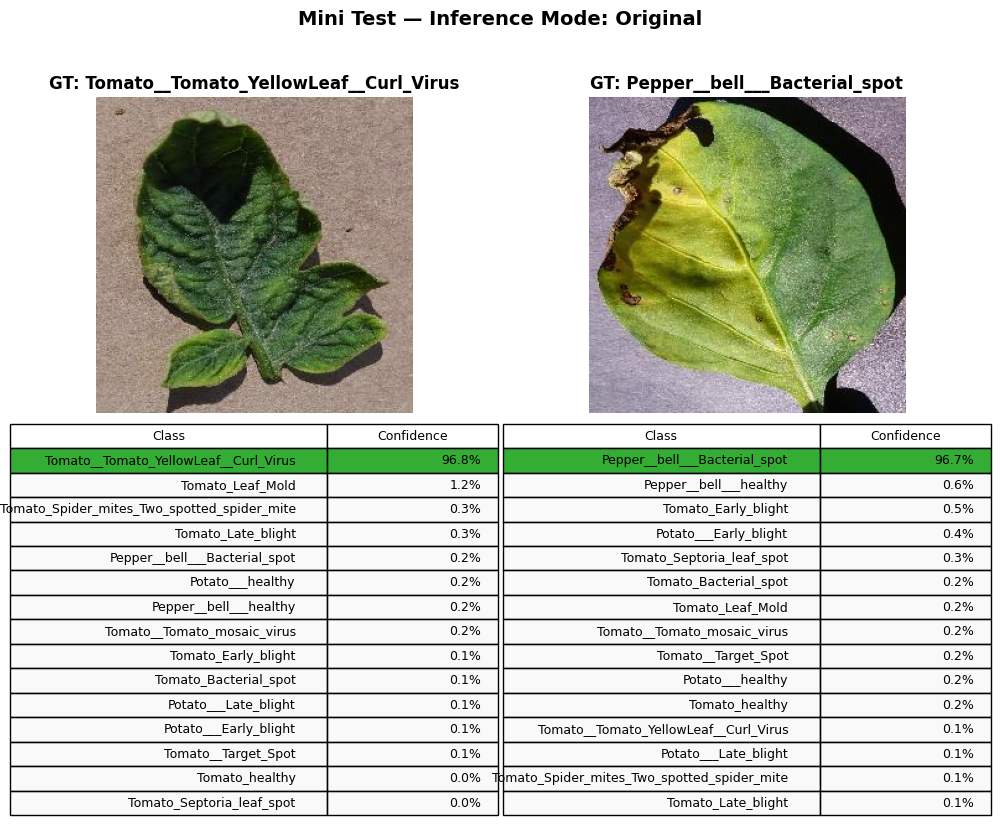

Saved figure to: /content/stage2_eval/mini_test_panel.png


In [21]:
# =========================================================
# Mini Test Visualization
# Original vs Leaf-only inference

import cv2, random, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input

# ===== Paths =====
SPLIT_ROOT = Path("/content/plantdisease_split")
MODEL_PATH = "outputs/stage2/M_final.keras"
SAVE_PATH  = "/content/stage2_eval/mini_test_panel.png"

# ===== Settings =====
EVAL_MODE = "orig"   # "orig" | "leaf"
N_SAMPLES = 2
IMG_SIZE  = (224,224)
rng = random.Random()  # true randomness

# ===== Load model =====
model = load_model(MODEL_PATH, compile=False)

# ===== Import preprocessing (same as training) =====
from src.utils import leaf_only_black

# ===== Helpers =====
def preprocess_for_model(rgb):
    if EVAL_MODE == "leaf":
        return leaf_only_black(rgb)
    else:
        img = cv2.resize(rgb, IMG_SIZE, interpolation=cv2.INTER_AREA)
        return preprocess_input(img.astype(np.float32))

def pick_test_files(root: Path, k: int):
    files = []
    for cls in sorted([d for d in (root/"test").iterdir() if d.is_dir()]):
        files.extend([(cls.name, p) for p in glob(str(cls/"*"))])
    return rng.sample(files, k=min(k, len(files)))

# ===== Class names (stable, from folders) =====
class_names = sorted([d.name for d in (SPLIT_ROOT/"test").iterdir() if d.is_dir()])

# ===== Pick samples =====
picked = pick_test_files(SPLIT_ROOT, N_SAMPLES)

# ===== Plot: image + prediction table =====
cols, rows = N_SAMPLES, 2
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = np.atleast_2d(axes)

for i, (gt_cls, path) in enumerate(picked):
    rgb = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    x = preprocess_for_model(rgb)[None, ...]

    probs = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_cls = class_names[pred_idx]
    correct = (pred_cls == gt_cls)

    # ---- Image ----
    ax_img = axes[0, i]
    ax_img.imshow(rgb)
    ax_img.axis("off")
    ax_img.set_title(f"GT: {gt_cls}", fontsize=12, weight="bold")

    # ---- Prediction table ----
    ax_tbl = axes[1, i]
    ax_tbl.axis("off")

    order = np.argsort(probs)[::-1]
    labels = [class_names[j] for j in order]
    scores = [f"{probs[j]*100:.1f}%" for j in order]

    cell_colors = []
    for j in order:
        if j == pred_idx:
            color = (0,0.6,0,0.8) if correct else (0.8,0,0,0.85)
        else:
            color = (0.95,0.95,0.95,0.4)
        cell_colors.append([color, color])

    tbl = ax_tbl.table(
        cellText=list(zip(labels, scores)),
        colLabels=["Class", "Confidence"],
        cellColours=cell_colors,
        loc="center",
        colWidths=[0.65, 0.35]
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1.2, 1.3)

# ===== Finalize =====
plt.suptitle(
    f"Mini Test — Inference Mode: {'Leaf-only' if EVAL_MODE=='leaf' else 'Original'}",
    fontsize=14, weight="bold", y=1.02
)
plt.tight_layout()
plt.savefig(SAVE_PATH, dpi=300, bbox_inches="tight")
plt.show()

print("Saved figure to:", SAVE_PATH)


# Conclusion



This repo or study proposed a two-stage deep learning framework for plant disease classification.
The approach successfully reduces background bias while preserving high classification accuracy, demonstrating improved robustness and generalization.
